### Image to image translation: pix2pix gan
Pix2pix gans are a sort of gans that are able to learn the mapping  between pairs of images. For example it can learn to transform black and white images into colorful images, turn google map photos into aerial images and also turn drawings into colorful images. 
This notebook is an attempt to train a pix2pix gan that learns the mapping between the drawing of a shoe and the actual RGB image of the shoe.

#### The dataset and preprocessing

The [dataset](https://www.kaggle.com/datasets/balraj98/edges2shoes-dataset) consists of shoe RGB images and their corresponding edges images(drawings). It is available on Kaggle.
Below is an sample from the dataset


In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import random

The dataset contains overall about 50K pairs of images, but we will only take the first 1000 images for training and the following 100 for testing. This in order to reduce the computational time of training the model.

In [2]:
data_dir = "/home/basaadi/projects/gan_trans/data/train"
sample_paths = glob.glob(data_dir+"/*.jpg")
training_sample_paths = sample_paths[:1000]
test_sample_paths = sample_paths[1000:1100]
print(f"len sample paths : {len(training_sample_paths)}")
print(f"len test_sample_paths  : {len(test_sample_paths)}")

len sample paths : 1000
len test_sample_paths  : 100


RBG images and their corresponding edge images are concatenated, this is why we should split every sample data into half. One corresponding to the image and the other to the edges.
This function read_image does exactly that.

In [3]:
def read_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_image(image, channels=3)
    width = tf.shape(image)[1]
    width_half = width//2

    input_image = image[:,:width_half,:]
    target_image = image[:,width_half:,:]

    input_image = tf.cast(input_image, dtype=tf.float32) 
    target_image = tf.cast(target_image, dtype=tf.float32)
    return input_image, target_image

Normalization is an important step in data preprocessing, as it helps the deep learning model avoid the covariate shift, and speeds its learning.
Every image is normalized between 0 and 1.

In [4]:
def normalize(input_image, target_image):
    input_image = (input_image / 127.5) - 1
    target_image = (target_image / 127.5) - 1
    return input_image, target_image

The two previous two functions are combined in the preprocess_fn, which refer to the preprocessing of the data.

In [5]:
def preprocess_fn(image_path):
    input_image, target_image = read_image(image_path)
    input_image, target_image = normalize(input_image, target_image)
    return input_image, target_image

Next a random sample is chosen from the dataset and ploted using the matplotlib library.

In [6]:
sample_path = random.choice(training_sample_paths)
input_image, target_image = preprocess_fn(sample_path)


2022-04-10 15:27:46.013333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-10 15:27:46.029783: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-10 15:27:46.030646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-04-10 15:27:46.031568: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the app

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


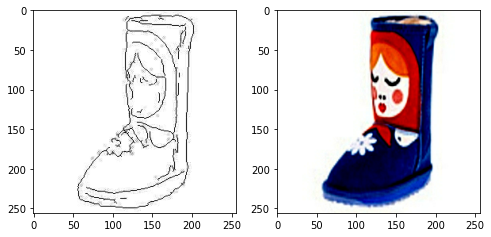

In [7]:
fig, axs = plt.subplots(1,2,figsize=(8,8))
axs[0].imshow(input_image)
axs[1].imshow(target_image)

As we can't load all our data into memory at once due to the large size of the dataset. We use the TensorFlow dataset, which plays the role of a generator that reads data from disk and preprocesses it on the fly. The advantage of using such a generator is that it optimizes the use of both CPU and GPU, that is by loading data using the CPU while the GPU is training the network. 

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 16

train_dataset = tf.data.Dataset.from_tensor_slices(training_sample_paths)
train_dataset = train_dataset.map(preprocess_fn, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(100)
train_dataset = train_dataset.batch(batch_size)


In [9]:
num = 0
for sample in train_dataset:
    num += 1
print(num)

63


Now that the dataset is ready. The next step is to define the genrator and the discriminator networks that will be trained on the dataset on an adverserial way.
Let's first begin by the generator.

The generator is a [U-Net](https://arxiv.org/pdf/1505.04597.pdf) like architecture. 
This architecture consists of an encoder that encodes the input image into a representation in a latent space. The second component is the decoder that maps the learned representation of the image into the desired output. 
This network was first designed for semantic segmentation. It gets an image as the input and learns the segmentation mask corresponding to the image.

The building block of the U-Net is convolution, pooling, and upsampling layers. The convolution extracts features, the pooling helps increase the receptive field of the encoder and the upsampling doubles the size of its input at each dimension . 
Both the encoder and the decoder use convolutional layers followed by batch normalization and relu activation. In order to avoid writing explicitly the operation for every step, it is better to group these repeated operations in one block.

#### GAN Network

In [10]:
# definition du modele
class Block(tf.keras.layers.Layer):
    def __init__(self,  out_ch):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(out_ch, (4, 4), 2,kernel_initializer='he_normal', padding='same')
        self.BatchNormalization1 = tf.keras.layers.BatchNormalization()
        self.leaky_relu1  = tf.keras.layers.LeakyReLU(alpha=0.01)

    def call(self, x):
        x = self.conv1(x)
        x = self.BatchNormalization1(x)
        x = self.leaky_relu1(x)
        return x
        
    def model(self, input_shape):
        x = tf.keras.Input(input_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))


To make sure that the block has the desired behavior, a method called "model" was included in the Block class. This helps print the summary of the Block.

In [11]:
block = Block(30)
print(block.model((256,256,1)).summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 30)      510       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 30)     120       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 30)      0         
                                                                 
Total params: 630
Trainable params: 570
Non-trainable params: 60
_________________________________________________________________
None


The Encoder consists of a series of convolutions followed by batch normalization and relu activation function.  

In [12]:

class Encoder(tf.keras.layers.Layer):    
    def __init__(self, chs=(32,64, 128, 256, 512)):
        super().__init__()
        self.enc_blocks = [Block(ch) for ch in chs]
    
    def call(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
        return ftrs
        
    def model(self, input_shape):
        x = tf.keras.Input(input_shape)
        return tf.keras.Model(inputs=[x], outputs=self.call(x))

The encoder take an array of dimension (256,256,3) and outputs and array of dimension (1, 1, 512)

In [13]:
encoder = Encoder(chs=(64, 128, 256, 512, 512, 512, 512, 512))
print(encoder.model((256,256,1)).summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 block_1 (Block)             (None, 128, 128, 64)      1344      
                                                                 
 block_2 (Block)             (None, 64, 64, 128)       131712    
                                                                 
 block_3 (Block)             (None, 32, 32, 256)       525568    
                                                                 
 block_4 (Block)             (None, 16, 16, 512)       2099712   
                                                                 
 block_5 (Block)             (None, 8, 8, 512)         4196864   
                                                                 
 block_6 (Block)             (None, 4, 4, 512)         4196

For every step, the decoder up-convolves its input then concatenates it with the corresponding output of the encoder, the operations in the Block are applied to the concatenated tensor.

In [14]:
class Decoder(tf.keras.layers.Layer):
# class Decoder(tf.keras.layers.Layer):
    def __init__(self, chs=(64, 32, 16)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = [tf.keras.layers.Conv2DTranspose(ch, (4, 4), strides=(2, 2), padding='same') for ch in chs[1:]]
        self.dec_blocks = [Block(chs[i]) for i in range(1, len(chs))]
        
    def call(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            x        = tf.keras.layers.concatenate([x, encoder_features[i]])
        return x
        
    # def model(self, input_shape):
    #     x = tf.keras.Input(input_shape)
    #     return tf.keras.Model(inputs=[x], outputs=self.call(x))

So, the generator is composed of the encoder followed by the decoder, and lastly another up-convolution layer in order for the output to have the same dimension as that of the input.

In [15]:

class Generator(tf.keras.Model):
    def __init__(self, enc_chs=(64, 128, 256, 512, 512, 512, 512, 512), dec_chs=(512,512,512,512,512, 256, 128, 64),num_channels=3):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.conv = tf.keras.layers.Conv2DTranspose(num_channels, (4, 4), strides=(2, 2), padding='same')

    def call(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.conv(out)
        return out
    

In [16]:
generator = Generator()
generator.build(input_shape=(1,256,256,1))
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  19545792  
                                                                 
 decoder (Decoder)           multiple                  34867648  
                                                                 
 conv2d_transpose_7 (Conv2DT  multiple                 6147      
 ranspose)                                                       
                                                                 
Total params: 54,419,587
Trainable params: 54,413,571
Non-trainable params: 6,016
_________________________________________________________________


The discriminator is equivalent to the encoder part of the Generator. It takes as input both the RBG image and the edges image concatenated together in the channels dimension. Then it outputs a probability map of dimension (30,30). The probability map indicates whether the edges image (drawing) corresponds to the RGB image or not. If the drawing corresponds to the RBG image (real data), the map should ideally be all ones, otherwise it should be all filled with zeros.

In [17]:
class Discriminator(tf.keras.Model):
    def __init__(self, enc_chs=[64,128,256]):
        super().__init__()
        self.initializer = tf.random_normal_initializer(0.0, 0.02)
        self.zero_pad1 = tf.keras.layers.ZeroPadding2D()
        self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
        self.conv1 = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=self.initializer, use_bias=False)
        self.conv2 = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=self.initializer, activation='sigmoid')
        
        self.batch_norm1 = tf.keras.layers.BatchNormalization()
        self.batch_norm2 = tf.keras.layers.BatchNormalization()
        
        self.leaky_relu = tf.keras.layers.LeakyReLU()
        self.enc_blocks = [Block(ch) for ch in enc_chs]

    def call(self, x1, x2):
        x = tf.keras.layers.concatenate([x1, x2])
        for enc_block in self.enc_blocks:
            x = enc_block(x)
        
        x = self.zero_pad1(x)
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = self.leaky_relu(x)
        x = self.zero_pad2(x)
        output = self.conv2(x)

        return output
    
    def model(self, input_shape=[256,256,3]):
        x1 = tf.keras.Input(shape=input_shape)
        x2 = tf.keras.Input(shape=input_shape)

        return tf.keras.Model(inputs=[x1,x2], outputs=self.call(x1,x2))
        

In [18]:
discriminator = Discriminator(enc_chs=[64,128,256])
print(discriminator.model().summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate (Concatenate)      (None, 256, 256, 6)  0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']          

In order to train both the generator and the discriminator a loss function should be defined. 
First of all, let's remember that the generator is given an edge image in its input and is required to output an RGB image of the edge image.
The generator's loss function is a composed of two sub-functions:
- The binary cross entropy: in order to push the generator in the direction of generating images that the discriminator will label as real (even though they aren't).
- The Mean absolute error (between the original RBG image and the generated image): in order to measure the difference between the generated image, and the real one.

The total loss is a weighted sum of both the binary cross entropy and the L1 loss function.

#### Loss functions

In [19]:
def generator_loss(disc_generated_output, gen_output, target, real_labels):
    Lambda = 100

    loss1 = tf.keras.losses.BinaryCrossentropy()
    loss2 = tf.keras.losses.MeanAbsoluteError()

    bce_loss = loss1(real_labels, disc_generated_output)  
    l1_loss = loss2(target, gen_output)

    total_gen_loss = bce_loss + Lambda*l1_loss

    return total_gen_loss, bce_loss, l1_loss

The Discriminator is given at its input a pair containing the drawing and its corresponding image. The discriminator is then required to classify the pair as being true or fake. Ideally, the true pairs should output a (30x30) probability map filled with ones,, and the fake pairs should output a map filled with zeros.
The discriminator's loss is a binary cross entropy.

In [20]:
def discriminator_loss(disc_real_output, disc_generated_output, real_labels, fake_labels):

    loss = tf.keras.losses.BinaryCrossentropy()

    bce_loss_real = loss(real_labels, disc_real_output)
    bce_loss_fake = loss(fake_labels, disc_generated_output)
    total_loss = bce_loss_real + bce_loss_fake

    return total_loss

#### Optimizers

Now that the loss function is defined, an optimization strategy should be defined. The Adam optimizer was defined for both the Generator and the Discriminator.

In [21]:
generator = Generator()
discriminator = Discriminator()
generator_optimizer = tf.keras.optimizers.Adam((2e-4), beta_1=0.5, beta_2=0.999)
discriminator_optimizer = tf.keras.optimizers.Adam((2e-4), beta_1=0.5, beta_2=0.999)

#### Training

Now everything is ready for training the model. The training strategy is the following:
- First , the generator is given a edge image (input_image) and generated an RGB image (gen_output). 
- The discriminator is given the edge image (input_image) and the true RGB image (target), and outputs a probability map (disc_real_output) corresponding to the likelihood that the pair is real.
- The discriminator is given the edge image (input_image) and the generated RGB image(gen_output), and outputs a map (disc_generated_output) corresponding to the likelihood that the pair is real.
- generate the ground truth probability map for the real pair, which is a map full of ones.
- generate the ground truth probability map for the fake pair, which is a map full of zeros.
- compute the generator's loss 
- compute the discriminator's loss
- compute the gradient of the dicriminator's loss with respect to the discriminator's trainable parameters.
- compute the gradient of the generator's loss with respect to the generator's trainable parameters.
- apply the gradient to the discriminator's trainable parameters using the defined optimizer.
- apply the gradient to the generator's trainable parameters using the defined optimizer.

In [22]:
@tf.function
def train_step(inputs):
    input_image, target = inputs

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator(input_image, target)

        disc_generated_output = discriminator(input_image, gen_output, training=True)
        
        real_targets = tf.ones_like(disc_real_output)
        fake_targets = tf.zeros_like(disc_real_output)

        gen_total_loss, gen_gan_loss, l1_loss = generator_loss(disc_generated_output, gen_output, target, real_targets)

        disc_loss = discriminator_loss(disc_real_output, disc_generated_output, real_targets, fake_targets)

        gen_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

        return gen_gan_loss, l1_loss, disc_loss


The training consists of iterating over all batches of the dataset for a determined number of epochs, and applying the train step function defined above.
The losses are printed at the end of every epoch in order to follow the training of the model.

In [23]:
def fit(epochs=100):
    for epoch in range(epochs):
        num_batches = 0
        gan_loss, l1_loss, disc_loss = 0, 0, 0
        for dist_inputs in train_dataset:
            num_batches +=1
            gan_l, l1_l, disc_l = train_step(dist_inputs)
            gan_loss += gan_l
            l1_loss += l1_l
            disc_loss += disc_l

        gan_loss = gan_loss/num_batches
        l1_loss = l1_loss/num_batches
        disc_loss = disc_loss/num_batches

        print(f"Epoch: {epoch}: D_Loss: {disc_loss}: G_Loss: {gan_loss}: l1_loss: {l1_loss}")

In [ ]:
epochs = 100
fit(epochs)

In [ ]:
generator.save_weights('gen'+str(epochs)+".h5")

#### Testing the trained model

In [24]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_sample_paths)
test_dataset = test_dataset.map(preprocess_fn, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.shuffle(100)
test_dataset = test_dataset.batch(2)

In [25]:
generator = Generator()
generator.build((1,256,256,3))
generator.load_weights("gen100.h5")

In [30]:
for img, target in test_dataset.take(1):
    preds = generator(img, training=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


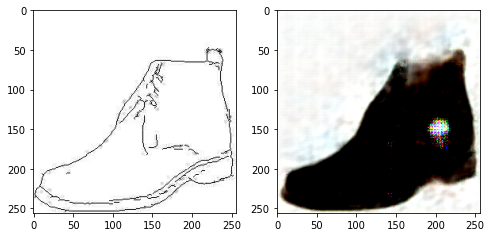

In [31]:
fig, axs = plt.subplots(1,2,figsize=(8,8))
axs[0].imshow(img[0,:,:,:])
axs[1].imshow(preds[0,:,:,:])

#### sources
- https://learnopencv.com/paired-image-to-image-translation-pix2pix/
- https://www.kaggle.com/datasets/balraj98/edges2shoes-dataset
- https://amaarora.github.io/2020/09/13/unet.html